# 2-x-filter Overlay - Demostration Notebook

通过HLS高层次综合工具，可以很方便的通过C/C++语言将算法综合为可在Vivado中直接例化的硬件IP，利用FPGA并行计算的优势，帮助我们实现算法加速，提高系统响应速度。在本示例中通过HLS工具实现了一个阶数与系数均可实时修改的FIR滤波器IP。

2-x-filter Overlay实现了对该滤波器的系统集成，里面包含了2个FIR滤波器，Block Design如下图所示，ARM处理器可通过AXI总线和DMA访问该IP。
<img src="./images/2-x-order_filter.PNG"/>
*注：Overlay可以理解为具体的FPGA比特流 + 相应的Python API驱动*
Address Map如下图所示：
<img src="./images/AddressMap.PNG"/>
而在PYNQ框架下，通过Python API我们可以很方便的对Overlay中的IP进行调用。而基于Python的生态，导入数据分析库如numpy和图形库matplotlib，通过简单的几行代码即可对FIR滤波器进行分析和验证。在本notebook中我们展示了通过numpy库产生的多个频率的叠加信号作为FIR滤波器的输入，并对经过FIR滤波器滤波前后的信号在时域和频频进行了分析。

下表为HLS工具自动为IP产生的驱动头文件，在notebook中需要对照该头文件来对IP进行调用。

 ==============================================================    
 File generated on Mon Oct 07 01:59:23 +0800 2019    
 Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2018.3 (64-bit)    
 SW Build 2405991 on Thu Dec  6 23:38:27 MST 2018    
 IP Build 2404404 on Fri Dec  7 01:43:56 MST 2018    
 Copyright 1986-2018 Xilinx, Inc. All Rights Reserved.    
     
==============================================================    
 AXILiteS    
 0x00 : Control signals    
        bit 0  - ap_start (Read/Write/COH)    
        bit 1  - ap_done (Read/COR)    
        bit 2  - ap_idle (Read)    
        bit 3  - ap_ready (Read)    
        bit 7  - auto_restart (Read/Write)    
        others - reserved    
 0x04 : Global Interrupt Enable Register    
        bit 0  - Global Interrupt Enable (Read/Write)    
        others - reserved    
 0x08 : IP Interrupt Enable Register (Read/Write)    
        bit 0  - Channel 0 (ap_done)    
        bit 1  - Channel 1 (ap_ready)    
        others - reserved    
 0x0c : IP Interrupt Status Register (Read/TOW)    
        bit 0  - Channel 0 (ap_done)    
        bit 1  - Channel 1 (ap_ready)    
        others - reserved    
 0x10 : Data signal of coe    
        bit 31~0 - coe[31:0] (Read/Write)    
 0x14 : reserved    
 0x18 : Data signal of ctrl    
        bit 31~0 - ctrl[31:0] (Read/Write)    
 0x1c : reserved    
 (SC = Self Clear, COR = Clear on Read, TOW = Toggle on Write, COH = Clear on Handshake)

为了帮助我们在notebook上对算法进行验证，我们通过matlab工具设计了2个滤波器，预设信号频率分量最高为750Hz，根据采样定理知采样频率要大于信号频率2倍，在设计的2个滤波器中，均设置扫描频率为1800Hz。

下图为在matlab中设计的的FIR低通滤波器幅频曲线，示例中设计了1个截至频率为500Hz的10阶FIR低通滤波器。
<img src="./images/MagnitudeResponse.PNG" width="70%" height="70%"/>
导出系数：[107,280,-1193,-1212,9334,18136,9334,-1212,-1193,280,107]

修改滤波器设置，重新设计1个截至频率为500Hz的15阶FIR高通滤波器.
<img src="./images/MagnitudeResponse_500Hz_HP.png" width="70%" height="70%"/>
导出系数：[-97,-66,435,0,-1730,1101,5506,-13305,13305,-5506,-1101,1730,0,-435,66,97]

# 步骤1 - 导入Python库，实例化用于控制FIR滤波器的DMA设备。
### 注：我们可以通过“Shift + Enter”组合键来逐一执行notebook中每一个cell内的python脚本。cell左边的"*"号表示脚本正在执行，执行完毕后会变为数字。

In [1]:
#导入必要的python库
import pynq.lib.dma #导入访问FPGA内侧DMA的库
import numpy as np #numpy为pyrhon的数值分析库
from pynq import Xlnk #Xlnk()可实现连续内存分配，访问FPGA侧的DMA需要该库
from scipy.fftpack import fft,ifft #python的FFT库
import matplotlib.pyplot as plt #python图表库
import scipy as scipy

In [2]:
#加载FPGA比特流
firn = pynq.Overlay("2-x-order_filter.bit")

In [43]:
#实例化Overlay内的x_order_fir_0和DMA0模块
dma_0 = firn.axi_dma_0
fir_filter_0 = firn.x_order_fir_0

In [44]:
#实例化Overlay内的x_order_fir_1和DMA1模块
dma_1 = firn.axi_dma_1
fir_filter_1 = firn.x_order_fir_1

In [45]:
#对Overlay内的DMA进行配置，每次传输1800个数据点。
xlnk = Xlnk()
in_buffer_0 = xlnk.cma_array(shape=(1800,), dtype=np.int32)
out_buffer_0 = xlnk.cma_array(shape=(1800,), dtype=np.int32)

in_buffer_1 = xlnk.cma_array(shape=(1800,), dtype=np.int32)
out_buffer_1 = xlnk.cma_array(shape=(1800,), dtype=np.int32)

In [46]:
#coe_buffer = xlnk.cma_array(shape=(11,), dtype=np.int32)
coe_buffer_0 = xlnk.cma_array(shape=(16,), dtype=np.int32)
ctrl_buffer_0 = xlnk.cma_array(shape=(2,), dtype=np.int32)

coe_buffer_1 = xlnk.cma_array(shape=(16,), dtype=np.int32)
ctrl_buffer_1 = xlnk.cma_array(shape=(2,), dtype=np.int32)

In [47]:
#coe = [107,280,-1193,-1212,9334,18136,9334,-1212,-1193,280,107]
coe_0 = [-97,-66,435,0,-1730,1101,5506,-13305,13305,-5506,-1101,1730,0,-435,66,97]
for i in range (16):
    coe_buffer_0[i] = coe[i]

In [48]:
coe_1 = [-97,-66,435,0,-1730,1101,5506,-13305,13305,-5506,-1101,1730,0,-435,66,97]
for i in range (16):
    coe_buffer_1[i] = coe[i]

In [49]:
ctrl_buffer_0[0] = 1
#ctrl_buffer[1] = 10
ctrl_buffer_0[1] = 16

In [50]:
ctrl_buffer_1[0] = 1
#ctrl_buffer[1] = 10
ctrl_buffer_1[1] = 16

In [51]:
coe_buffer_0.physical_address

402993152

In [52]:
fir_filter_0.write(0x10,coe_buffer_0.physical_address)
fir_filter_0.write(0x18,ctrl_buffer_0.physical_address)

In [53]:
fir_filter_1.write(0x10,coe_buffer_1.physical_address)
fir_filter_1.write(0x18,ctrl_buffer_1.physical_address)

In [54]:
fir_filter_0.write(0x00,0x81)
fir_filter_1.write(0x00,0x81)

# 步骤2 - 叠加多个不同频率和幅值的信号，作为滤波器的输入信号。

In [55]:
#采样频率为1800Hz，即1秒内有1800个采样点，我们将采样点个数选择1800个。
x=np.linspace(0,1,1800)

Text(0.5,1,'input signal')

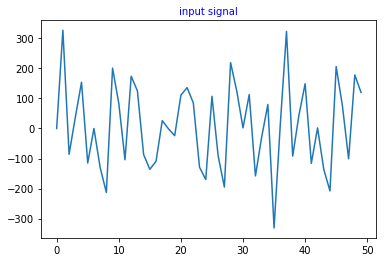

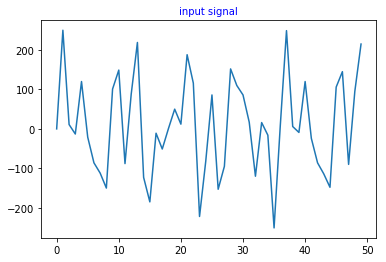

In [56]:
#产生滤波器输入信号
f1 = 600 #设置第1个信号分量频率设置为600Hz
a1 = 100 #设置第1个信号分量幅值设置为100
f2 = 450 #设置第2个信号分量频率设置为450Hz
a2 = 100 #设置第2个信号分量幅值设置为100
f3 = 200 #设置第3个信号分量频率设置为200Hz
a3 = 100 #设置第3个信号分量幅值设置为100
f4 = 650 #设置第4个信号分量频率设置为650Hz
a4 = 100 #设置第5个信号分量幅值设置为100

#产生2个不同频率分量的叠加信号，将其作为滤波器的输入信号，我们还可以叠加更多信号。
#y=np.int32(a1*np.sin(2*np.pi*f1*x) + a2*np.sin(2*np.pi*f2*x)) 
y_0=np.int32(a1*np.sin(2*np.pi*f1*x) + a2*np.sin(2*np.pi*f2*x) + a3*np.sin(2*np.pi*f3*x) + a4*np.sin(2*np.pi*f4*x)) 

#绘制滤波器输入信号波形图
fig_0_1 = plt.figure()
ax_0_1 = fig_0_1.gca()
plt.plot(y_0[0:50]) #为便于观察，这里仅显示前50个点的波形，如需要显示更多的点，请将50改为其它数值
plt.title('input signal',fontsize=10,color='b')

y_1=np.int32(a1*np.sin(2*np.pi*f1*x) + a2*np.sin(2*np.pi*f2*x) + a3*np.sin(2*np.pi*f3*x)) 

#绘制滤波器输入信号波形图
fig_1_1 = plt.figure()
ax_1_1 = fig_1_1.gca()
plt.plot(y_1[0:50]) #为便于观察，这里仅显示前50个点的波形，如需要显示更多的点，请将50改为其它数值
plt.title('input signal',fontsize=10,color='b')

In [57]:
#通过DMA将数据发送in_buffer内的数值到FIR滤波器的输入端
for i in range(1800):
    in_buffer_0[i] = y_0[i]
dma_0.sendchannel.transfer(in_buffer_0)

In [58]:
#通过DMA将数据发送in_buffer内的数值到FIR滤波器的输入端
for i in range(1800):
    in_buffer_1[i] = y_1[i]
dma_1.sendchannel.transfer(in_buffer_1)

In [59]:
#获取滤波器的输出信号数据存储在out_buffer中
dma_0.recvchannel.transfer(out_buffer_0)

In [60]:
#获取滤波器的输出信号数据存储在out_buffer中
dma_1.recvchannel.transfer(out_buffer_1)

Text(0.5,1,'output signal')

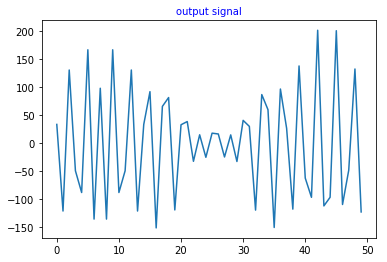

In [61]:
#绘制滤波器输出信号图
fig_0_2 = plt.figure()
ax_0_2 = fig2.gca()
plt.plot(out_buffer_0[0:50]/32768) #除于32768的原因是滤波器系数为16位有符号定点小数，运算过程中被当作整数计算。
plt.title('output signal',fontsize=10,color='b')

Text(0.5,1,'output signal')

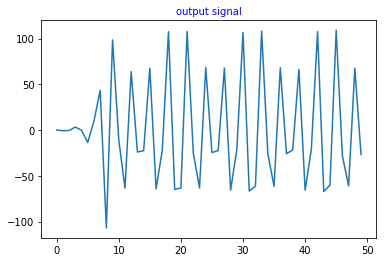

In [62]:
#绘制滤波器输出信号图
fig_1_2 = plt.figure()
ax_1_2 = fig2.gca()
plt.plot(out_buffer_1[0:50]/32768) #除于32768的原因是滤波器系数为16位有符号定点小数，运算过程中被当作整数计算。
plt.title('output signal',fontsize=10,color='b')

# 步骤3 - 对滤波器输入和输出信号做频域分析

In [63]:
#FFT变换函数体
def fft(signal_buffer,points):
    yy = scipy.fftpack.fft(signal_buffer)
    yreal = yy.real               # 获取实部
    yimag = yy.imag               # 获取虚部
    yf1 = abs(yy)/((len(points)/2))  #归一化处理
    yf2 = yf1[range(int(len(points)/2))]  #由于对称性，只取一半区间
    xf1 = np.arange(len(signal_buffer))        # 频率
    xf2 = xf1[range(int(len(points)/2))]  #取一半区间
    #混合波的FFT（双边频率范围）
    #plt.subplot(222)
    plt.plot(xf2,yf2,'r') #显示原始信号的FFT模值,本例只显示其中的750个点，如需要显示更多请调整750为其它数值
    plt.title('FFT of Mixed wave',fontsize=10,color='r')  #注意这里的颜色可以查询颜色代码
    return

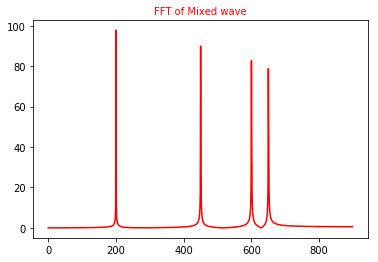

In [64]:
#对输入信号做FFT变换
fft(in_buffer_0,x)

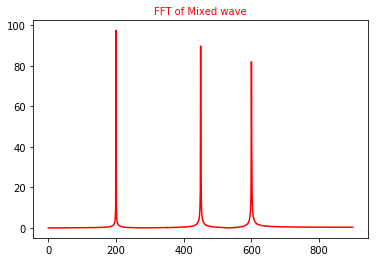

In [65]:
#对输入信号做FFT变换
fft(in_buffer_1,x)

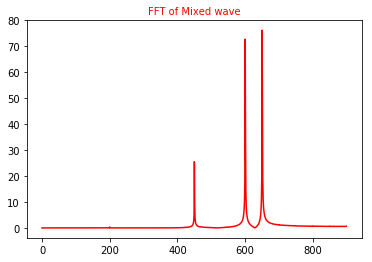

In [66]:
#对输出信号做FFT变换
fft(out_buffer_0/32768,x)#除于32768的原因是滤波器系数为16位有符号定点小数，运算过程中被当作整数计算。

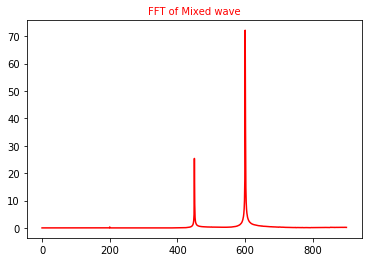

In [67]:
#对输出信号做FFT变换
fft(out_buffer_1/32768,x)#除于32768的原因是滤波器系数为16位有符号定点小数，运算过程中被当作整数计算。

In [68]:
#dma.sendchannel.wait()
#dma.recvchannel.wait()

In [69]:
in_buffer_0.close()
out_buffer_0.close()
in_buffer_1.close()
out_buffer_1.close()

In [20]:
xlnk.xlnk_reset()